# Project Title: Image Classification and object detection for Cifar100 dataset.

# Problem Statement
The objective of this project is to develop a Convolutional Neural Network (CNN) capable of classifying images in the CIFAR-100 dataset into 100 distinct categories. The dataset contains 32x32 color images, and the project involves optimizing the model architecture, using advanced techniques such as SE (Squeeze-and-Excitation) blocks, batch normalization, and data augmentation, to achieve higher accuracy. This notebook also includes loading and saving models for deployment purposes.


## Project Submission Details
- Name: Mayank Pant
- Roll No.: 2201331540108
- Batch: Batch 3, Lab 001B

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Step 1: Load CIFAR-100 Dataset
The dataset is split into training and testing sets with 100 fine-grained labels.


In [ ]:
# Step 1: Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

## Step 2: Normalize Data
Normalize pixel values to the range [0, 1] for better training performance.


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


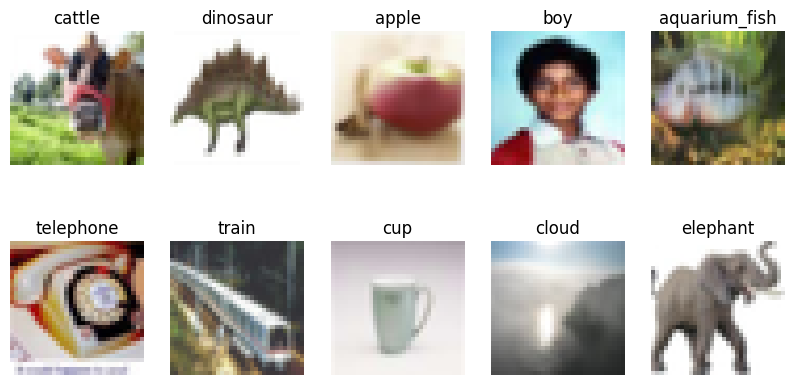

In [2]:
# Step 2: Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Step 3: Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

# Full list of CIFAR-100 class names
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
           'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
           'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
           'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
           'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
           'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar',
           'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
           'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Display sample images with corrected indexing
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    # Use the raw label from the dataset (not one-hot encoded)
    plt.title(classes[np.argmax(y_train[i])])
    plt.axis('off')
plt.show()

## Step 5: Define CNN Model Architecture
This model includes SE blocks, Batch Normalization, and Dropout for regularization.


In [3]:
# Define the SE block for channel recalibration
def se_block(input_tensor, ratio=8):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    return layers.multiply([input_tensor, se])

# Input layer
inputs = Input(shape=(32, 32, 3))

# Block 1
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = se_block(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Block 2
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = se_block(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Block 3
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = se_block(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Fully connected layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation='softmax')(x)

# Define the model
model = models.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │            520 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │            576 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ multiply[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ batch_normalization_3… │
│ (GlobalAveragePooling

 Total params: 1,353,884 (5.16 MB)

 Trainable params: 1,352,092 (5.16 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Step 7: Train the Model
Train the CNN on the CIFAR-100 dataset with 50 epochs and batch size of 100.


In [4]:
# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=10000,
    decay_rate=0.9
)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # Reduced rotation range
    width_shift_range=0.1,  # Reduced width shift
    height_shift_range=0.1,  # Reduced height shift
    shear_range=0.1,  # Reduced shear range
    zoom_range=0.1,  # Reduced zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)


# Fit the model using augmented data
datagen.fit(x_train)

# Check if GPU is available
device_name = tf.test.gpu_device_name()
if not device_name:
    print("GPU device not found. Please enable GPU in Colab settings.")
else:
    print(f"Found GPU at: {device_name}")

# Explicitly set TensorFlow to use GPU
with tf.device(f'{device_name}'):
    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model with augmented data
    history = model.fit(datagen.flow(x_train, y_train, batch_size=100),
                        epochs=200, validation_data=(x_test, y_test))

Found GPU at: /device:GPU:0
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 90ms/step - accuracy: 0.0723 - loss: 4.4359 - val_accuracy: 0.0586 - val_loss: 4.6611
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.1983 - loss: 3.4700 - val_accuracy: 0.2297 - val_loss: 3.4976
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.2781 - loss: 2.9877 - val_accuracy: 0.3310 - val_loss: 2.7844
Epoch 4/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.3405 - loss: 2.6582 - val_accuracy: 0.3960 - val_loss: 2.4237
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.3889 - loss: 2.4292 - val_accuracy: 0.3500 - val_loss: 2.6594
Epoch 6/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.4211 - loss: 2.2483 - val_accuracy: 0.4471 - val_loss: 2.2061
Epoch 7/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.4488 - loss: 2.1408 - val_accuracy: 0.4333 - val_loss: 2.2564
Epoch 8/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.4638 - loss: 2.0526 - val_

## Step 8: Evaluate Model Performance
Test the model on the CIFAR-100 test set and compute accuracy.


In [5]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

313/313 - 1s - 3ms/step - accuracy: 0.6658 - loss: 1.6446
Test accuracy: 0.67


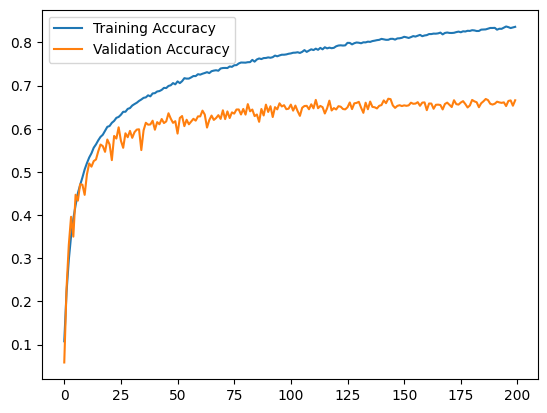

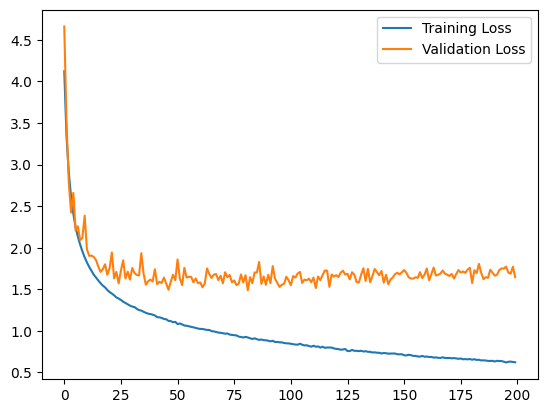

In [6]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


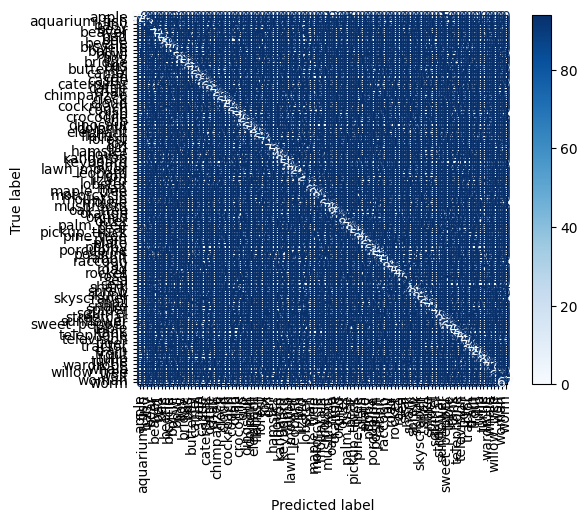

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()


In [8]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=classes)
print(report)


               precision    recall  f1-score   support

        apple       0.94      0.82      0.88       100
aquarium_fish       0.85      0.75      0.80       100
         baby       0.62      0.53      0.57       100
         bear       0.55      0.45      0.49       100
       beaver       0.42      0.44      0.43       100
          bed       0.74      0.71      0.72       100
          bee       0.69      0.77      0.73       100
       beetle       0.67      0.72      0.69       100
      bicycle       0.69      0.83      0.75       100
       bottle       0.82      0.70      0.76       100
         bowl       0.49      0.45      0.47       100
          boy       0.50      0.55      0.52       100
       bridge       0.75      0.80      0.78       100
          bus       0.69      0.55      0.61       100
    butterfly       0.63      0.67      0.65       100
        camel       0.71      0.71      0.71       100
          can       0.70      0.66      0.68       100
       ca

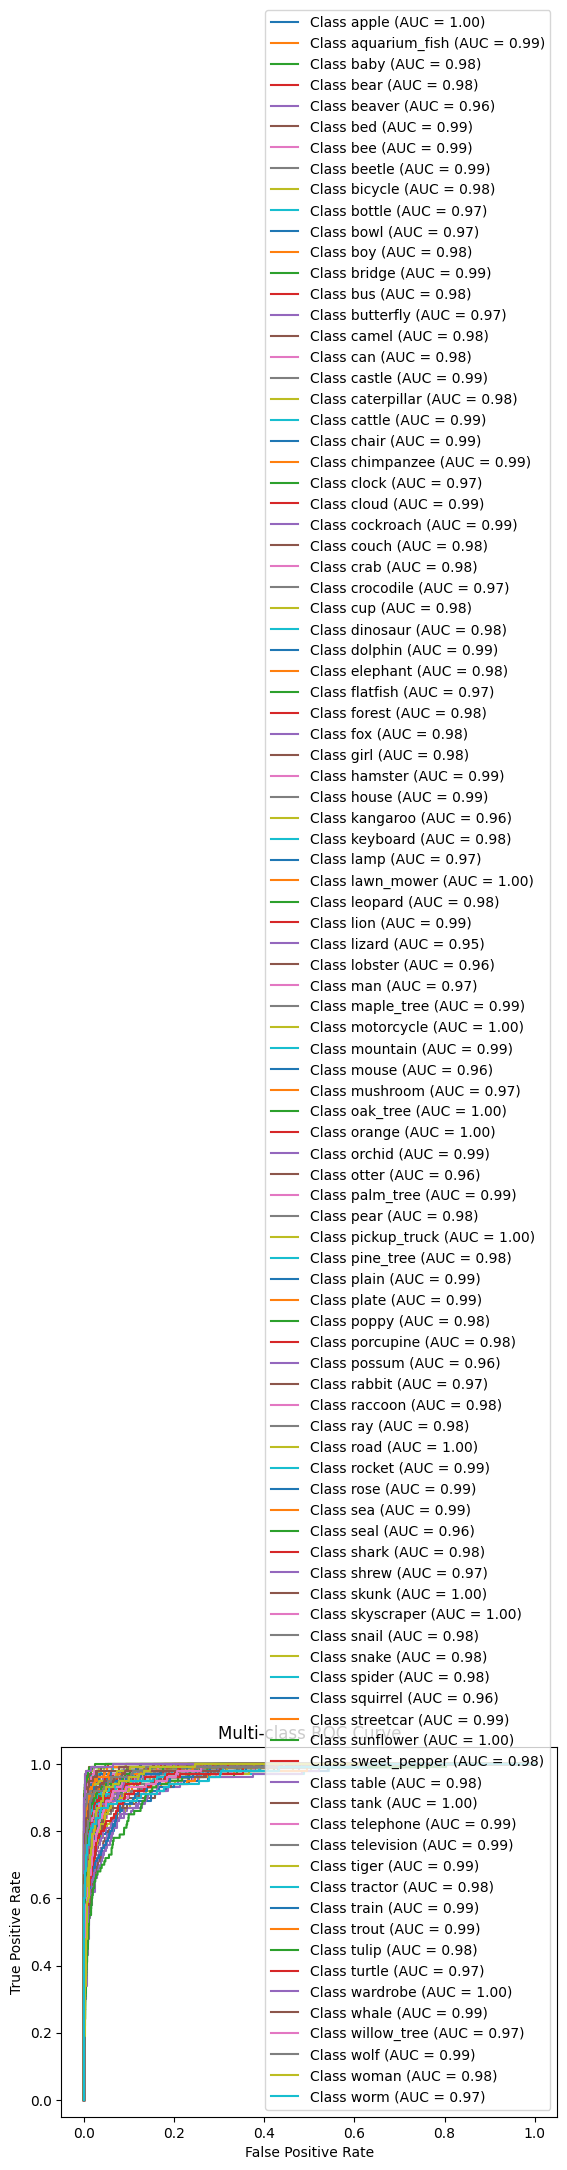

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_test_binarized = label_binarize(y_true_classes, classes=range(len(classes)))

# Compute ROC curve and AUC for each class
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


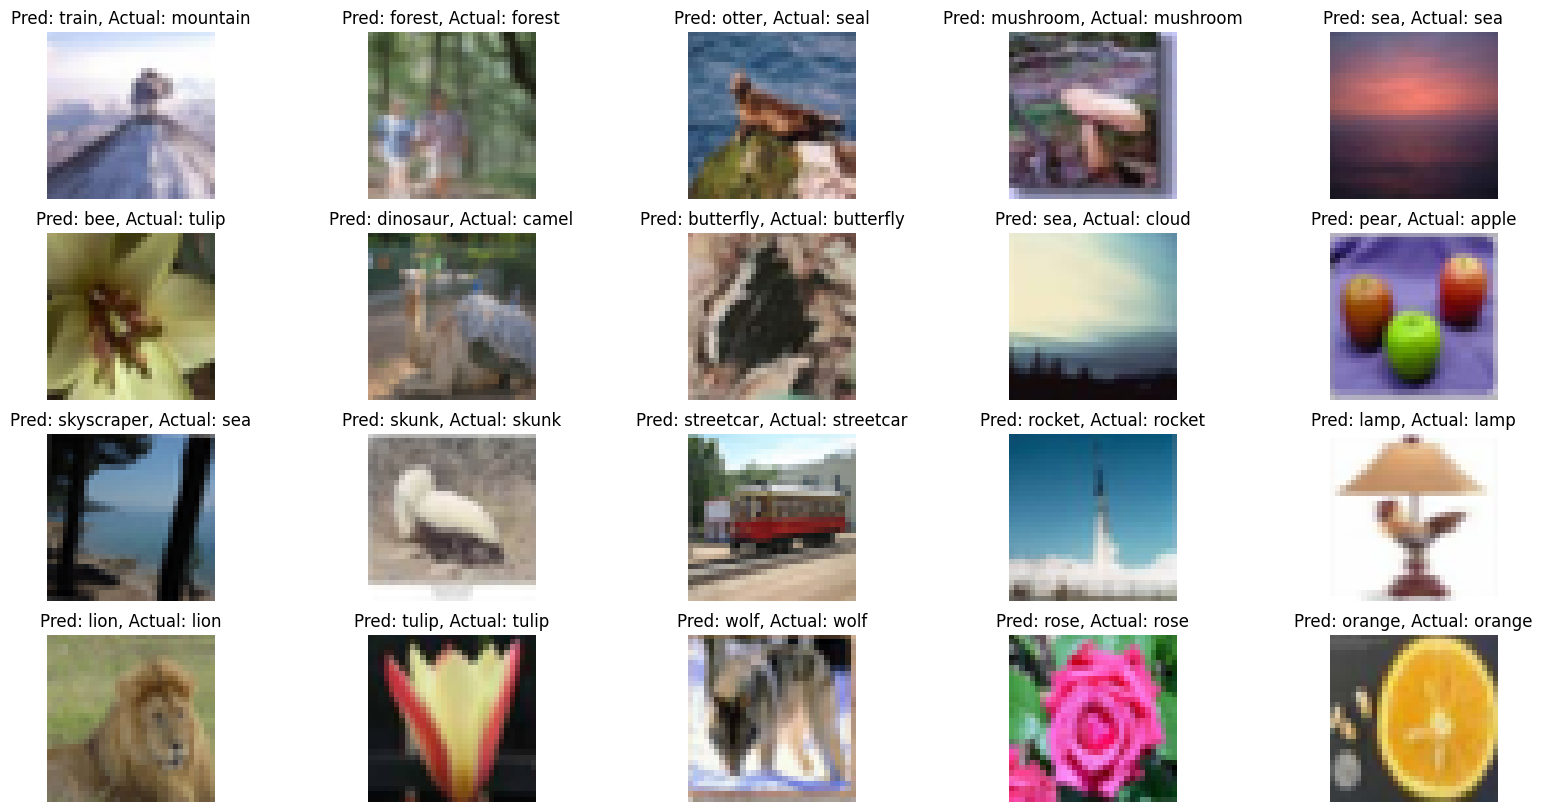

In [10]:
# Step 9: Display predictions for test images
predictions = model.predict(x_test)
plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"Pred: {classes[np.argmax(predictions[i])]}, Actual: {classes[np.argmax(y_test[i])]}")
    plt.axis('off')
plt.show()

## Step 10: Save and Load Models
Save the trained model for reuse and deployment in `.keras` format.


In [11]:
# Step 10: Save the model
model.save('cifar100_67_model.keras')

model.save('cifar100_67_model.h5')  # Saves in HDF5 format

import pickle

# Extract model weights and architecture
model_weights = model.get_weights()
model_config = model.to_json()

# Save them as a pickle file
with open('cifar100_67_model.pkl', 'wb') as f:
    pickle.dump({'weights': model_weights, 'config': model_config}, f)

# Step 11: Load and test the saved model
loaded_model = models.load_model('cifar100_67_model.keras')

#loaded_model = tf.keras.models.load_model('cifar100_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


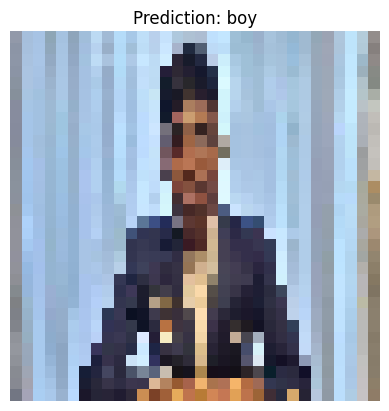

In [14]:
from tensorflow.keras.preprocessing import image

# Path to the image
image_path = '/content/praggnanandhaa.png'

# Load the image
img = image.load_img(image_path, target_size=(32, 32))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict the image
predictions = loaded_model.predict(img_array)
plt.imshow(img)
plt.title(f"Prediction: {classes[np.argmax(predictions)]}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


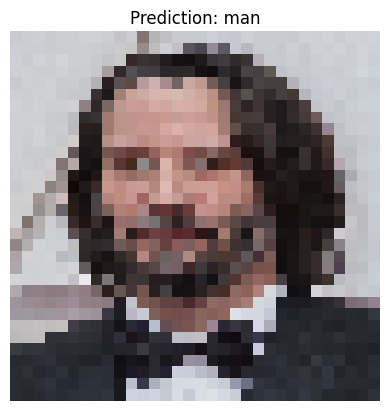

In [16]:
# Path to the image
image_path = '/content/keanu_reeves.jpg'

# Load the image
img = image.load_img(image_path, target_size=(32, 32))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict the image
predictions = loaded_model.predict(img_array)
plt.imshow(img)
plt.title(f"Prediction: {classes[np.argmax(predictions)]}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


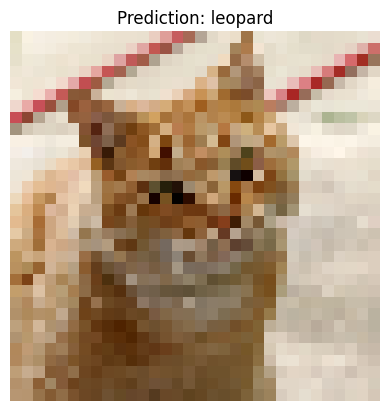

In [20]:
# Path to the image
image_path = '/content/cat.webp'

# Load the image
img = image.load_img(image_path, target_size=(32, 32))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict the image
predictions = loaded_model.predict(img_array)
plt.imshow(img)
plt.title(f"Prediction: {classes[np.argmax(predictions)]}")
plt.axis('off')
plt.show()